In [2]:
# Bibliotecas além do gerenciador Anaconda
!pip install spacy
!python -m spacy download pt_core_news_sm
!pip install wordcloud
!pip install gensim
!pip install tensorflow

2022-05-31 12:08:13.016760: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-31 12:08:13.017931: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [3]:
# Módulos básicos para manuseio de dados e arquivos
import numpy as np
import pandas as pd
import os
from os.path import isfile, join
import nltk
import re
import string
import unicodedata
import json

# Módulos para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud
%matplotlib inline

# Módulo para processamento de linguagem
import spacy

## Carregamento de textos

In [4]:
limited_news_path = r'Software\Fake.br-Corpus' #\fake_10 or \true_10
news_path = r'Software\Fake.br-Corpus\full_texts' #\fake or \true

paths = [limited_news_path, news_path]

In [5]:
def sortDir(dir_path: str, is_meta=False) ->list:
    '''
    Ordena os arquivos dentro de dir_path e os retorna no formato de lista.
    '''
    if is_meta:
        number_separator = "-meta.txt"
    else:
        number_separator = ".txt"

    first_list = os.listdir(dir_path)
    int_list = [int(element.split(number_separator)[0]) for element in first_list]
    int_list.sort()
    final_list = [(str(element) + number_separator) for element in int_list]

    return final_list

def txtToDataframe(path, is_limited=True):
    '''
    Function for converting full texts to a single DataFrame.
    '''
    if is_limited:
        true_files = [path+"\\true_10\\"+f for f in sortDir(dir_path = path+'\\true_10') if isfile(join(path+'\\true_10', f))]
        fake_files = [path+"\\fake_10\\"+f for f in sortDir(dir_path = path+'\\fake_10') if isfile(join(path+'\\fake_10', f))]
    else:
        true_files = [path+"\\true\\"+f for f in sortDir(dir_path = path+'\\true') if isfile(join(path+'\\true', f))]
        fake_files = [path+"\\fake\\"+f for f in sortDir(dir_path = path+'\\fake') if isfile(join(path+'\\fake', f))]
    
    texts = []
    labels = []
    
    for file in true_files:
        with open(file, encoding='utf-8-sig') as f:
            texts.append(f.read())
            labels.append(0)
    for file in fake_files:
        with open(file, encoding='utf-8-sig') as f:
            texts.append(f.read())
            labels.append(1)
            
    df = pd.DataFrame(list(zip(texts,labels)),columns=['texts','labels'])
    
    # Com esta função, textos e labels foram inseridos em um DataFrame de maneira sequencial. Todas as notícias verdadeiras vêm
    # ANTES do bloco de notícias falsas.
    
    return df

def appendMetadata(path,df, is_limited=True):
    '''
    Function for appending metadata to previously generated news DataFrame.
    '''
    if is_limited:
        true_meta = [path+"\\true-meta-information-10\\"+f for f in sortDir(dir_path = path+'\\true-meta-information-10',is_meta=True) if isfile(join(path+'\\true-meta-information-10', f))]
        fake_meta = [path+"\\fake-meta-information-10\\"+f for f in sortDir(dir_path = path+'\\fake-meta-information-10',is_meta=True) if isfile(join(path+'\\fake-meta-information-10', f))]
    else:
        true_meta = [path+"\\true-meta-information\\"+f for f in sortDir(dir_path = path+'\\true-meta-information',is_meta=True) if isfile(join(path+'\\true-meta-information', f))]
        fake_meta = [path+"\\fake-meta-information\\"+f for f in sortDir(dir_path = path+'\\fake-meta-information',is_meta=True) if isfile(join(path+'\\fake-meta-information', f))]
    

    #true_meta e fake_meta são listas com todas os paths para arquivos de metadata.
    
    columns = ["author", "source", "category", "date","tokens","words_without_punctuation","types","number_of_links","uppercase_words","verbs","subjuntive_imperative","nouns","adjectives","adverbs","modal_verbs","singular_first_and_second_personal_pronouns","plural_first_personal_pronouns","pronouns","pausality","characters","avg_sentence_length","avg_word_length","percentage_of_spelling_errors","emotiveness","diversity"]
    
    true_metadata = pd.DataFrame(columns=columns)
    fake_metadata = pd.DataFrame(columns=columns)
    
    for file in true_meta:
        #print(file)
        aux = pd.read_csv(file, header=None, sep = '\n').transpose()
        aux.columns = columns
        true_metadata=true_metadata.append(aux)
        
        
    for file in fake_meta:
        #print(file)
        aux = pd.read_csv(file, header=None, sep = '\n').transpose()
        aux.columns = columns
        fake_metadata=fake_metadata.append(aux)
        
    
    metadata = pd.DataFrame(columns=columns)
    metadata = metadata.append(true_metadata,ignore_index=True)
    metadata = metadata.append(fake_metadata,ignore_index=True) 


    complete_df = pd.concat([df,metadata],axis=1)
    # Este DataFrame possui todos os textos/labels (2 colunas) e metadata (25 colunas).
    
    return complete_df

In [6]:
ai = int(input('''0 - Base com 10 notícias verdadeiras e 10 notícias falsas
1 - Base completa de notícias
'''))

path = paths[ai]

if ai == 0:
    data = txtToDataframe(path) # Dataframe contendo notícias e labels.
    complete_data = appendMetadata(path,data) # Dataframe contendo notícias, labels e metadata.
else:
    data = txtToDataframe(path,is_limited=False)
    complete_data = appendMetadata(path,data,is_limited=False)

0 - Base com 10 notícias verdadeiras e 10 notícias falsas
1 - Base completa de notícias
1


In [7]:
complete_data['texts'][14]

'Anthony Garotinho deixa Bangu com festa de aliados e ataques a Cabral\nEx-governador não usará tornozeleira, mas está impedido de deixar o país. Presidente do PR também saiu da cadeia; os dois foram beneficiados por decisão de Gilmar Mendes.\n\nO ex-governador do Rio de Janeiro Anthony Garotinho saiu do Complexo Penitenciário de Gericinó, em Bangu, na Zona Oeste, às 20h30 desta quinta-feira (21). Ele foi beneficiado por uma decisão do ministro Gilmar Mendes, presidente do Tribunal Superior Eleitoral (TSE).\n\nUm grupo de cerca de 20 pessoas, incluindo a filha dele, Clarissa Garotinho (PRB), fez festa na porta do presídio. Após cumprimentos, beijos e abraços, ele conversou com jornalistas. "Nada vai mudar as minhas convicções", disse ele.\n\nAnthony Garotinho e a mulher, a também ex-governadora Rosinha Matheus, foram presos no mês passado por crimes eleitorais em uma ação da Polícia Federal. Os dois negam as acusações.\n\nRosinha já respondia em liberdade. Garotinho agora também respon

## Preprocessamento de textos

In [8]:
# Carregando o pacote de língua portuguesa para o processador Spacy
nlp = spacy.load('pt_core_news_sm')

In [9]:
# Defininido funções de preprocessamento

def removePunct(text):
    '''
    Removes any punctuation included in string.punctuation.
    '''
    translator = text.maketrans({key:'' for key in string.punctuation+'“”'}) # Translates any punctuation into ''
    return text.translate(translator)

def removeNumbers(text):
    '''
    Removes any number character in text.
    '''
    return re.sub('[0-9]', '' , text) # Translates any number into ''

def removeStopWords(string):
    '''
    Removes any portuguese stopwords, using Spacy's standard package.
    '''
    doc = nlp(string)
    return ' '.join([token.text for token in doc if token.is_stop is False])

def lemmatize(string):
    '''
    Lemmatizes text word-by-word. Notice that lemmatizing is not as harsh as stemming, which makes the final text easier to read and understand in common language.
    '''
    doc = nlp(string)
    return ' '.join([token.lemma_ for token in doc])

def prep(string, useStopWords = False, lemma = False):
    '''
    Executes previously defined preprocessing in text.
    '''

    result = removeNumbers(removePunct(string)).lower()
    
    if useStopWords and lemma:
        doc = nlp(result)
        result = ' '.join([token.lemma_ for token in doc if token.is_stop is False])
    elif useStopWords:
        doc = nlp(result)
        result = ' '.join([token.text for token in doc if token.is_stop is False])
    elif lemma:
        doc = nlp(result)
        result = ' '.join([token.lemma_ for token in doc])

    result = result.replace('\n',"")
    
    return result

In [10]:
# Realizando preprocessamento de textos presentes no Dataframe de notícias completo.

complete_data['texts'] = complete_data['texts'].apply(prep)


# Assignando variáveis dependentes e independentes

y = complete_data['labels'].values # y is strings for labels; but should be fake-0/true-1
X = [d.split() for d in complete_data['texts'].tolist()] # X is a list of lists of words.

## Tokenization (TensorFlow)

In [11]:
# Importando módulos para tokenização de textos
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [12]:
# Assignando bases de teste e treino

test_limit = 0.10
training_sentences,testing_sentences,training_labels,testing_labels = train_test_split(X,y,test_size=test_limit, random_state=42)

#training_sentences = X[0:test_limit]
#testing_sentences = X[test_limit:]

#training_labels = y[0:test_limit]
#testing_labels = y[test_limit:]

In [13]:
# Análise e truncagem de sequências

def sequenceKill(min_length,max_length,training_sentences_local,training_labels_local,training_sequences_local):

    #plt.hist([len(x) for x in X], bins = 750)
    #plt.show()

    nos = np.array([len(x) for x in training_sentences_local])
    print("There are "+ str(len(nos[nos>=max_length])) + " news equal or longer than "+ str(max_length) + " words (will be truncated).")
    print("There are "+ str(len(nos[nos<min_length])) + " news shorter than "+ str(min_length) + " words (will be killed).")
    
    print("Final database will have "+str(len(training_sentences_local)-len(nos[nos<min_length]))+" total entries.")

    
    flag_dict = {}
    for i in range(0,len(training_sequences_local)):
        if len(training_sequences[i]) < min_length:
            flag_dict[i] = True
        else:
            flag_dict[i] = False

    training_labels_local = [training_labels_local[i] for i in range(0,len(flag_dict)) if (flag_dict[i] == False)]

    training_sequences_local = [seq for seq in training_sequences_local if len(seq)>=min_length]
    
    return training_sequences_local, training_labels_local

In [14]:
# Gerando dicionário de tokens (com base nos textos de treinamento)
tokenizer = Tokenizer()  # não utilizaremos o oov_token='<OOV>'
tokenizer.fit_on_texts(training_sentences)
vocab = tokenizer.word_index

# Realizando a sequencialização das bases de treinamento e teste
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

In [15]:
training_sequences

[[12739,
  1361,
  26214,
  7,
  4553,
  1,
  114,
  2245,
  3471,
  13687,
  14,
  5998,
  25,
  2409,
  4,
  97,
  2,
  3652,
  3701,
  7604,
  14,
  114,
  2245,
  2031,
  4,
  227,
  2075,
  3,
  587,
  24,
  2,
  2655,
  10,
  1299,
  109,
  73,
  3190,
  18,
  46,
  570,
  5,
  3,
  587,
  438,
  612,
  12739,
  1361,
  41,
  15,
  7604,
  5,
  1935,
  10,
  1053,
  8635,
  7,
  114,
  2245,
  14,
  759,
  148,
  5,
  17994,
  8,
  570,
  1,
  1780,
  133,
  17,
  41,
  9,
  63,
  4,
  15,
  26214,
  1,
  3173,
  25,
  418,
  6,
  4,
  1336,
  3,
  587,
  14,
  1656,
  15,
  11916,
  11,
  2409,
  5,
  198,
  13687,
  14,
  5998,
  43,
  40411,
  61,
  25,
  1,
  41,
  5,
  227,
  9001,
  3,
  587,
  24,
  2655,
  3,
  1299,
  15,
  206,
  2655,
  2,
  206,
  9443,
  5,
  241,
  1560,
  12,
  2,
  570,
  43,
  11917,
  1818,
  817,
  25,
  8805,
  25,
  13688,
  25,
  2409,
  6,
  4,
  97,
  3,
  9002,
  7,
  3652,
  5,
  26215,
  16,
  5436,
  5998,
  2,
  219,
  75,
  4,
  829,

In [16]:
# Analisando a base
# Eliminando menores e truncando maiores

min_length = 150
max_length = 500

training_sequences, training_labels = sequenceKill(min_length, max_length, training_sentences, training_labels,training_sequences)

training_padded = pad_sequences(training_sequences,maxlen=max_length,padding='post',truncating='pre')
#testing_padded = pad_sequences(testing_sequences,maxlen=max_length,padding='post',truncating='pre')

There are 2823 news equal or longer than 500 words (will be truncated).
There are 1586 news shorter than 150 words (will be killed).
Final database will have 4894 total entries.


## Vectorization (gensim)

In [17]:
import gensim

In [18]:
# Gerando o dicionário de vetores para cada palavra da base de treinamento

DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=training_sentences, vector_size=DIM, window=10, min_count=1)

In [19]:
w2v_model.wv.most_similar('bolsonaro')

[('jair', 0.8982441425323486),
 ('ciro', 0.761833906173706),
 ('presidenciável', 0.7538481950759888),
 ('psl', 0.7468670606613159),
 ('pscrj', 0.7288259863853455),
 ('précandidato', 0.7197296023368835),
 ('boulos', 0.7162144780158997),
 ('wyllys', 0.7140117287635803),
 ('jean', 0.7105655074119568),
 ('huck', 0.7009235620498657)]

## Criação da rede neural

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [23]:
# Assignando os vetores gerados para uma matriz de pesos, que será inserida na rede neural 

vocab_size = len(vocab)+1

def get_weight_matrix(model):
    ''' Inserts every word vector in a NumPy array, ordering them by token index (which is determined by their appearing frequencies). '''
    weight_matrix = np.zeros((vocab_size, DIM))

    for word, token in vocab.items():
        weight_matrix[token] = model.wv[word]

    return weight_matrix

embedding_vectors = get_weight_matrix(model=w2v_model)

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [embedding_vectors], input_length=max_length, trainable=False))
model.add(LSTM(units=100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          9235900   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 9,316,401
Trainable params: 80,501
Non-trainable params: 9,235,900
_________________________________________________________________


In [25]:
model.fit(training_padded, np.transpose(np.asarray(training_labels)), validation_split=0.3, epochs=10)

Epoch 1/10
108/108 [==============================] - 76s 551ms/step - loss: 0.3073 - acc: 0.8850 - val_loss: 0.2650 - val_acc: 0.9108
Epoch 2/10
108/108 [==============================] - 56s 522ms/step - loss: 0.2798 - acc: 0.8704 - val_loss: 0.2927 - val_acc: 0.9183
Epoch 3/10
108/108 [==============================] - 56s 523ms/step - loss: 0.2578 - acc: 0.9048 - val_loss: 0.2183 - val_acc: 0.9095
Epoch 4/10
108/108 [==============================] - 57s 527ms/step - loss: 0.2154 - acc: 0.9253 - val_loss: 0.2066 - val_acc: 0.9360
Epoch 5/10
108/108 [==============================] - 57s 531ms/step - loss: 0.2021 - acc: 0.9305 - val_loss: 0.2170 - val_acc: 0.9319
Epoch 6/10
108/108 [==============================] - 56s 515ms/step - loss: 0.1738 - acc: 0.9416 - val_loss: 0.1834 - val_acc: 0.9442
Epoch 7/10
108/108 [==============================] - 57s 524ms/step - loss: 0.1668 - acc: 0.9436 - val_loss: 0.2103 - val_acc: 0.9285
Epoch 8/10
108/108 [==============================] - 5

In [29]:
# Sequencialização e truncagem do conjunto de testes

sequences = tokenizer.texts_to_sequences(testing_sentences) # Sequencing testing sentences.
padded = pad_sequences(testing_sequences,maxlen=max_length,padding='post',truncating='pre')


#Tesntando acurácia do modelo na base de testes

y_pred = (model.predict(padded) >=0.5).astype(int)

print(accuracy_score(testing_labels, y_pred))
print(precision_score(testing_labels, y_pred))
print(recall_score(testing_labels, y_pred))
print(f1_score(testing_labels, y_pred))

0.9527777777777777
0.9353932584269663
0.9680232558139535
0.9514285714285714


## Salvando o modelo

In [36]:
def saveModel(model,dicto):
    name = input('nome do modelo:')
    model.save(str(name)+'.h5')
    with open('wordIndex.json','w') as f:
        json.dump(dicto,f,indent = "")
    print('Model saved!')
    return

saveModel(model, vocab)

nome do modelo:normal-trunc-150e500-1dense-100-1-acc96
Model saved!


## Matriz de confusão

In [28]:
import seaborn as sn

In [33]:
cm = tf.math.confusion_matrix(labels=testing_labels,predictions=y_pred)

Text(69.0, 0.5, 'Truth')

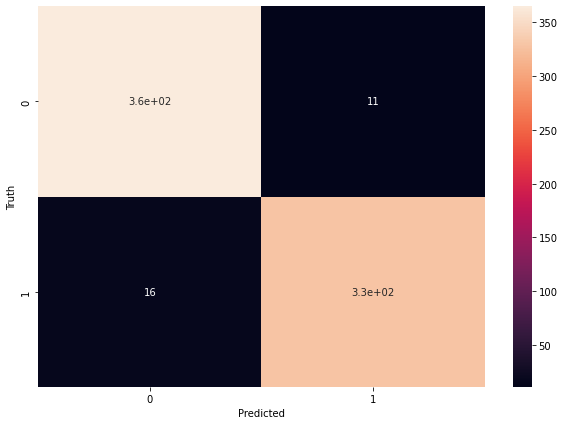

In [35]:
plt.figure(figsize= (10,7))
sn.heatmap(data=cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Buscando notícias

In [ ]:
testing_labels[14]

In [ ]:
testing_sentences[14]